# CNN 😎

In [1]:
import utilities as ff
import CNNModels

In [5]:
from tensorflow import config as tfconfig
from tensorflow.python.client import device_lib
try:
    print(tfconfig.list_physical_devices())
    print(device_lib.list_local_devices())
except:
    pass


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15952275034851264647
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1386046875
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10061032363582911234
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:02:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


https://www.tensorflow.org/tutorials/images/cnn

## HyperParameter

Parameters that could in particualr affect performance of a CNN model:

- Image size
- Colors
- Number of filters
- Number of layers
- Kernel size of filters

We propose 2 models to evaluate the latter 3, but first of all:

### Base Model

In [6]:
CNNModels.BASE().layers

### Thick model

- LESS LAYER
- MORE FILTERS
- ASCENDING KERNEL SIZE

In [7]:
CNNModels.THICK().layers

### Long Model

- MORE LAYERS
- LESS FILTERS
- DESCENDING KERNEL SIZE

In [8]:
CNNModels.LONG().layers

## Models

In [ ]:
# ff.delete_from_list()

### Base

Found 24770 files belonging to 2 classes.
Using 12385 files for training.
Found 24770 files belonging to 2 classes.
Using 12385 files for validation.
Epoch 1/24
310/310 [==============================] - 17s 46ms/step - loss: 0.6516 - accuracy: 0.6168 - val_loss: 0.5629 - val_accuracy: 0.7156
Epoch 2/24
310/310 [==============================] - 15s 47ms/step - loss: 0.5317 - accuracy: 0.7425 - val_loss: 0.4977 - val_accuracy: 0.7574
Epoch 3/24
310/310 [==============================] - 18s 58ms/step - loss: 0.4541 - accuracy: 0.7875 - val_loss: 0.4801 - val_accuracy: 0.7785
Epoch 4/24
310/310 [==============================] - 15s 49ms/step - loss: 0.3874 - accuracy: 0.8252 - val_loss: 0.4693 - val_accuracy: 0.7911
Epoch 5/24
310/310 [==============================] - 15s 48ms/step - loss: 0.3237 - accuracy: 0.8593 - val_loss: 0.5004 - val_accuracy: 0.7866
Epoch 6/24
310/310 [==============================] - 19s 59ms/step - loss: 0.2518 - accuracy: 0.8941 - val_loss: 0.5428 - val_acc

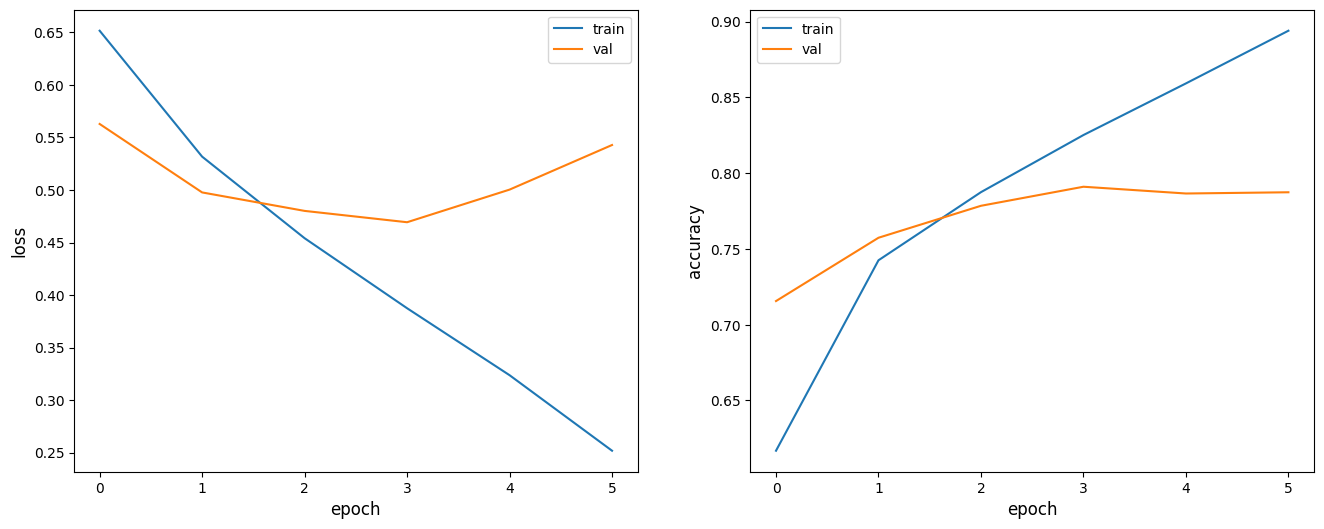

In [9]:
base_tag, base_test = ff.auto_train("BASE")

### Grayscale

Are color useless?

Found 24770 files belonging to 2 classes.
Using 12385 files for training.
Found 24770 files belonging to 2 classes.
Using 12385 files for validation.
Epoch 1/24
310/310 [==============================] - 19s 57ms/step - loss: 0.6862 - accuracy: 0.5492 - val_loss: 0.6960 - val_accuracy: 0.4860
Epoch 2/24
310/310 [==============================] - 17s 54ms/step - loss: 0.6629 - accuracy: 0.5980 - val_loss: 0.5961 - val_accuracy: 0.6840
Epoch 3/24
310/310 [==============================] - 17s 53ms/step - loss: 0.5748 - accuracy: 0.6999 - val_loss: 0.5425 - val_accuracy: 0.7213
Epoch 4/24
310/310 [==============================] - 17s 53ms/step - loss: 0.5036 - accuracy: 0.7548 - val_loss: 0.5020 - val_accuracy: 0.7594
Epoch 5/24
310/310 [==============================] - 17s 55ms/step - loss: 0.4345 - accuracy: 0.8015 - val_loss: 0.4949 - val_accuracy: 0.7659
Epoch 6/24
310/310 [==============================] - 16s 51ms/step - loss: 0.3733 - accuracy: 0.8340 - val_loss: 0.4835 - val_acc

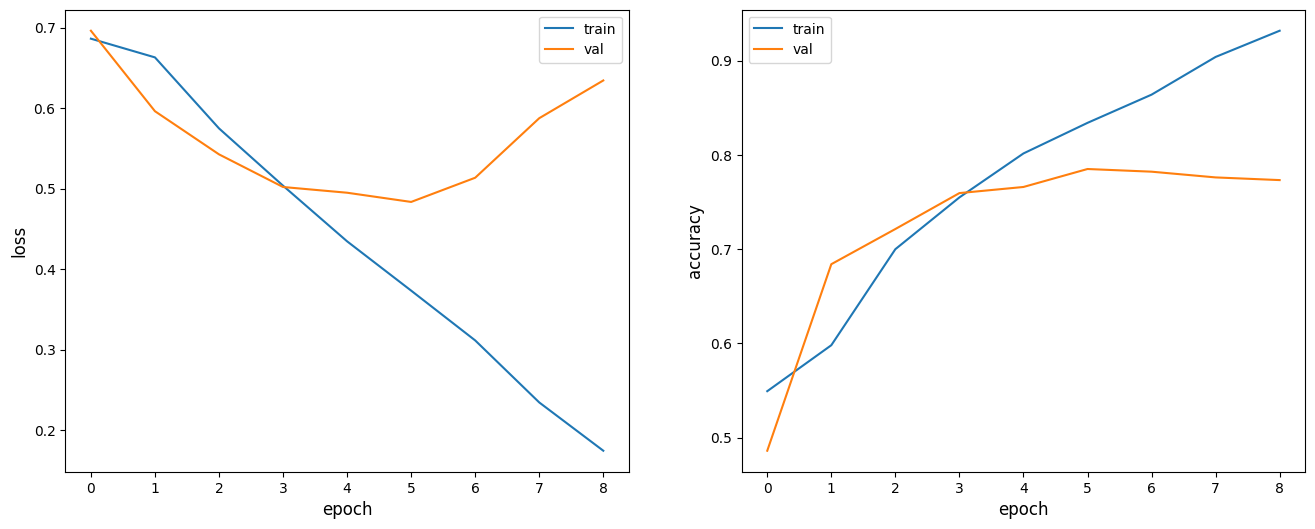

In [10]:
gray_tag, gray_test = ff.auto_train("BASE", color_mode="grayscale")

### Smaller images

Are high resolution images worth?

Found 24770 files belonging to 2 classes.
Using 12385 files for training.
Found 24770 files belonging to 2 classes.
Using 12385 files for validation.
Epoch 1/24
310/310 [==============================] - 18s 53ms/step - loss: 0.6274 - accuracy: 0.6348 - val_loss: 0.5498 - val_accuracy: 0.7310
Epoch 2/24
310/310 [==============================] - 16s 51ms/step - loss: 0.5306 - accuracy: 0.7379 - val_loss: 0.4891 - val_accuracy: 0.7570
Epoch 3/24
310/310 [==============================] - 16s 51ms/step - loss: 0.4731 - accuracy: 0.7760 - val_loss: 0.4654 - val_accuracy: 0.7846
Epoch 4/24
310/310 [==============================] - 16s 51ms/step - loss: 0.4258 - accuracy: 0.8070 - val_loss: 0.4318 - val_accuracy: 0.8126
Epoch 5/24
310/310 [==============================] - 16s 52ms/step - loss: 0.3809 - accuracy: 0.8281 - val_loss: 0.4458 - val_accuracy: 0.7972
Epoch 6/24
310/310 [==============================] - 16s 52ms/step - loss: 0.3458 - accuracy: 0.8497 - val_loss: 0.4541 - val_acc

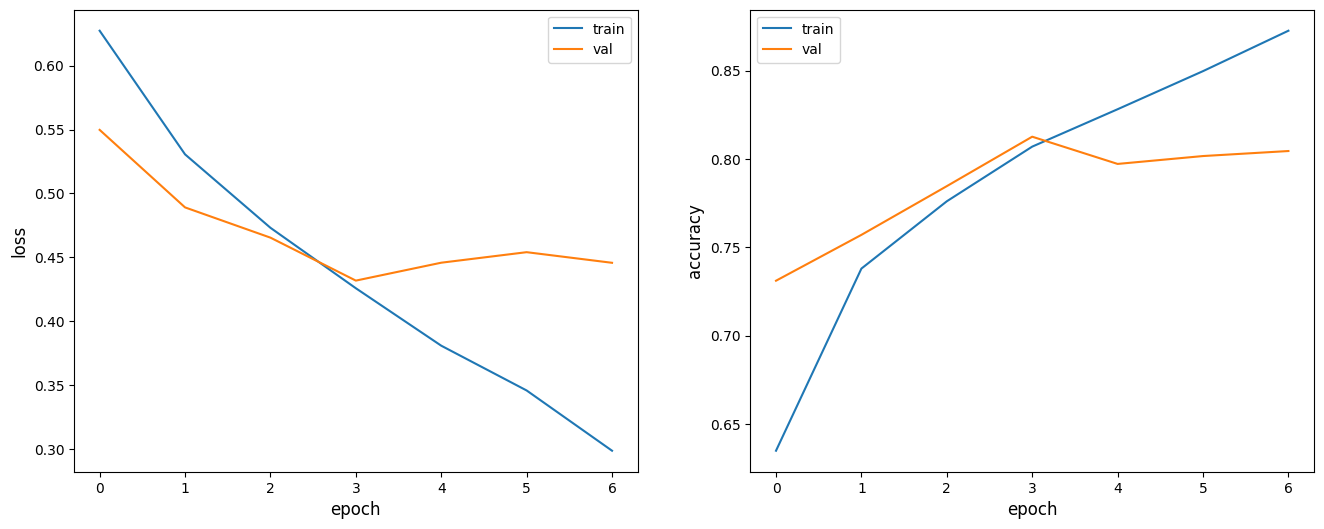

In [11]:
small_tag, small_test = ff.auto_train("BASE", image_size=64)

### Thick

Found 24770 files belonging to 2 classes.
Using 12385 files for training.
Found 24770 files belonging to 2 classes.
Using 12385 files for validation.
Epoch 1/24
310/310 [==============================] - 32s 98ms/step - loss: 0.6973 - accuracy: 0.5460 - val_loss: 0.6736 - val_accuracy: 0.5602
Epoch 2/24
310/310 [==============================] - 30s 96ms/step - loss: 0.6279 - accuracy: 0.6502 - val_loss: 0.5922 - val_accuracy: 0.6884
Epoch 3/24
310/310 [==============================] - 30s 96ms/step - loss: 0.5441 - accuracy: 0.7283 - val_loss: 0.5244 - val_accuracy: 0.7456
Epoch 4/24
310/310 [==============================] - 30s 96ms/step - loss: 0.4813 - accuracy: 0.7710 - val_loss: 0.4985 - val_accuracy: 0.7594
Epoch 5/24
310/310 [==============================] - 30s 98ms/step - loss: 0.4257 - accuracy: 0.8002 - val_loss: 0.4873 - val_accuracy: 0.7789
Epoch 6/24
310/310 [==============================] - 33s 105ms/step - loss: 0.3585 - accuracy: 0.8394 - val_loss: 0.4899 - val_ac

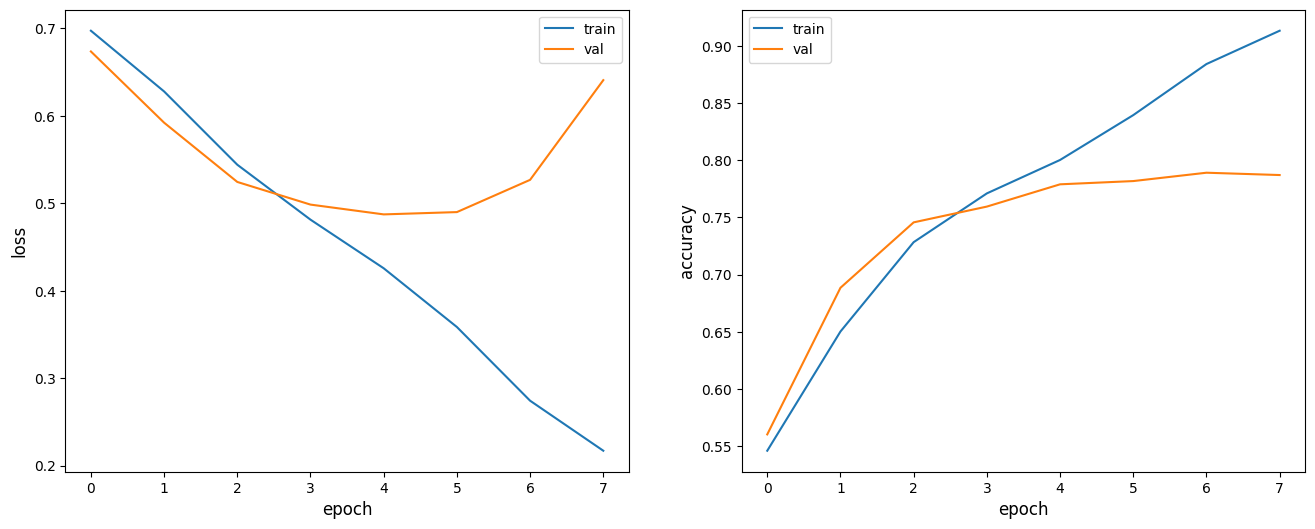

In [12]:
thick_tag, thick_test = ff.auto_train("THICK")

### Long

Found 24770 files belonging to 2 classes.
Using 12385 files for training.
Found 24770 files belonging to 2 classes.
Using 12385 files for validation.
Epoch 1/24
310/310 [==============================] - 26s 79ms/step - loss: 0.6933 - accuracy: 0.5021 - val_loss: 0.6932 - val_accuracy: 0.4824
Epoch 2/24
310/310 [==============================] - 24s 77ms/step - loss: 0.6932 - accuracy: 0.5004 - val_loss: 0.6932 - val_accuracy: 0.4751
Epoch 3/24
310/310 [==============================] - 24s 78ms/step - loss: 0.6932 - accuracy: 0.5030 - val_loss: 0.6932 - val_accuracy: 0.4799
Epoch 4/24
310/310 [==============================] - 24s 77ms/step - loss: 0.6932 - accuracy: 0.4985 - val_loss: 0.6934 - val_accuracy: 0.4791


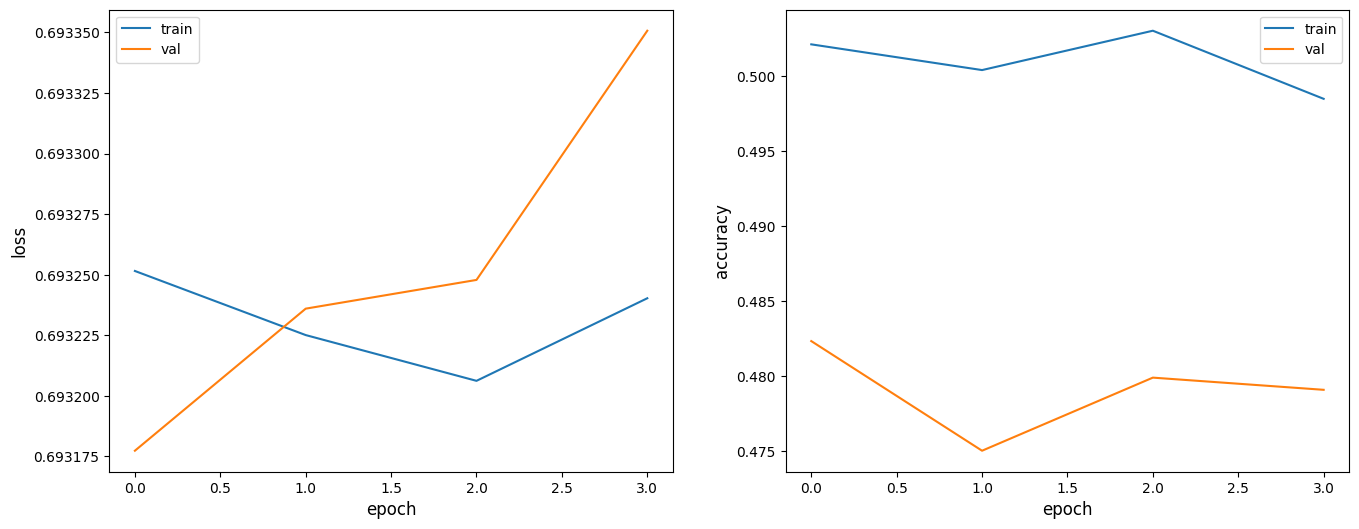

In [13]:
thick_tag, thick_test = ff.auto_train("LONG")

## Risk Estimation

Let's comprare best and worst model

In [17]:
# BEST
best_accuracies = ff.k_fold_cross_validation("BEST", small_test, "THICK")
best_avg_loss = 1 - sum(best_accuracies) / len(best_accuracies)

print("Risk estimation (average zero one loss): ", best_avg_loss)

Risk estimation (average zero one loss):  0.20917208194732662


In [20]:
# WORST
worst_accuracies = ff.k_fold_cross_validation("WORST", gray_test, "LONG")
worst_avg_loss = 1 - sum(worst_accuracies) / len(worst_accuracies)

print("Risk estimation (average zero one loss): ", worst_avg_loss)

Risk estimation (average zero one loss):  0.24366883039474485
